In [192]:
import pandas as pd

In [193]:
import sqlite3

# Define a function to fetch data from the database
def fetch_energy_data_as_dataframe(query : str , db_path : str):
    try:
        # Connect to the database
        with sqlite3.connect(db_path) as conn:
            # Use pandas to execute the query and return the result as a DataFrame
            df = pd.read_sql_query(query, conn)
            return df
    except sqlite3.DatabaseError as e:
        print(f"Database error: {e}")
        return None
    

# Example usage
db_path = 'data/time_series_production_prices.sqlite'  # replace with your actual database path
query = """
    SELECT utc_timestamp, cet_cest_timestamp, DE_solar_capacity, DE_solar_generation_actual, 
           DE_solar_profile, DE_wind_capacity, DE_wind_profile, DE_wind_offshore_generation_actual, 
           DE_wind_offshore_profile, DE_wind_onshore_capacity, DE_wind_onshore_generation_actual, 
           DE_wind_onshore_profile, DE_LU_price_day_ahead, ES_solar_generation_actual, 
           ES_wind_onshore_generation_actual
    FROM time_series_60min_singleindex;
    """

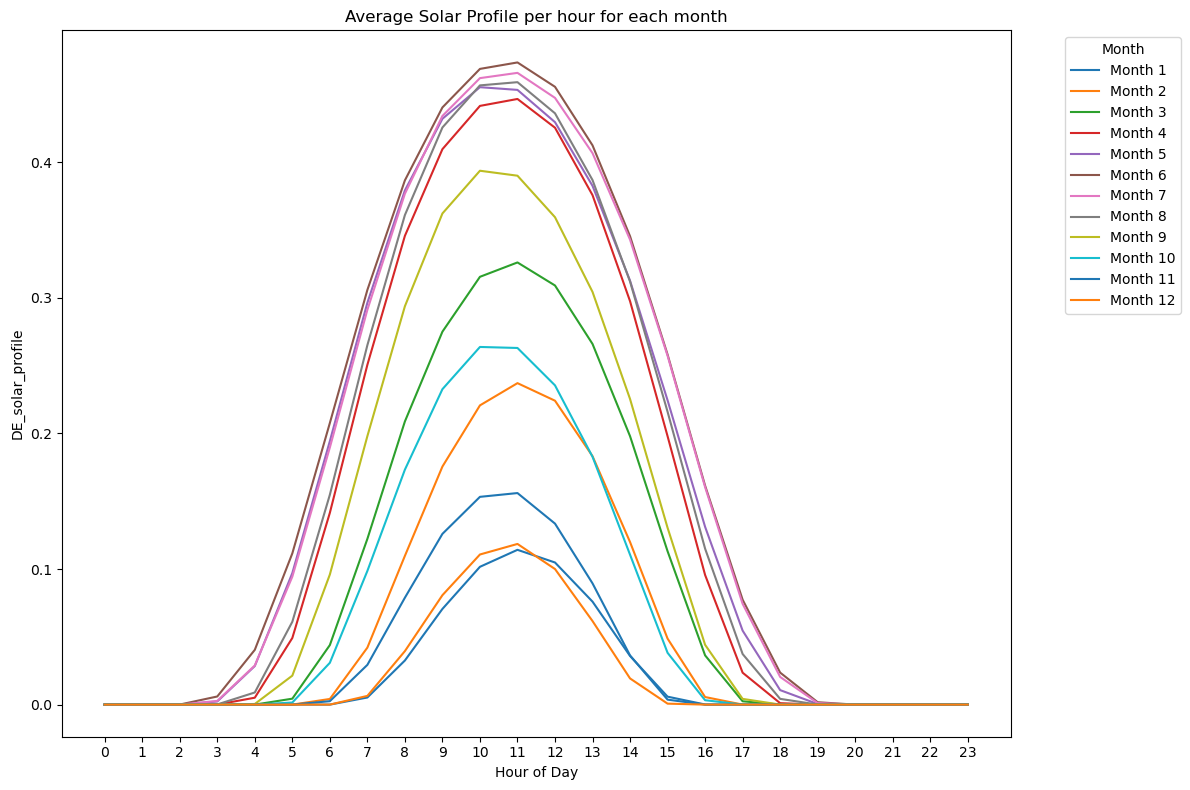

In [194]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure your DataFrame is already loaded into `per_year_average_ssolar_profile_per_hour`

per_year_average_ssolar_profile_per_hour  = fetch_energy_data_as_dataframe(query,db_path)

# Step 1: Convert 'utc_timestamp' to datetime and extract hour and month
per_year_average_ssolar_profile_per_hour['utc_timestamp'] = pd.to_datetime(per_year_average_ssolar_profile_per_hour['utc_timestamp'])
per_year_average_ssolar_profile_per_hour['hour'] = per_year_average_ssolar_profile_per_hour['utc_timestamp'].dt.hour
per_year_average_ssolar_profile_per_hour['month'] = per_year_average_ssolar_profile_per_hour['utc_timestamp'].dt.month

# Step 2: Group by hour and month, and calculate average DE_LU_price_day_ahead
avg_price_per_hour_month = per_year_average_ssolar_profile_per_hour.groupby(['month', 'hour'])['DE_solar_profile'].mean().reset_index()

# Step 3: Pivot the table for easy plotting (Month as rows, Hour as columns)
pivot_table = avg_price_per_hour_month.pivot(index='month', columns='hour', values='DE_solar_profile')

# Step 4: Plot the results
plt.figure(figsize=(12, 8))
plt.title('Average Solar Profile per hour for each month')
plt.xlabel('Hour of Day')
plt.ylabel('DE_solar_profile')

# Plot each month's average price per hour
for month in pivot_table.index:
    plt.plot(pivot_table.columns, pivot_table.loc[month], label=f'Month {month}')

plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(24))  # Ensure ticks for each hour of the day
plt.grid(False)
plt.tight_layout()


In [195]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot probability distribution for each hour (4 to 18), separated by season
def plot_hourly_distribution_by_season(df :pd.DataFrame):
    # Step 1: Convert 'utc_timestamp' to datetime (if not already done)
    df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
    df['hour'] = df['utc_timestamp'].dt.hour
    df['month'] = df['utc_timestamp'].dt.month

    # Step 2: Define summer and winter seasons
    df['season'] = df['month'].apply(lambda x: 'summer' if 4 <= x <= 8 else 'winter')

    # Step 3: Define hours range (4 to 18)
    hours_range = range(4, 19)  # 19 because the end is exclusive in Python ranges

    # Step 4: Create subplots for each hour in the range (15 subplots)
    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(18, 10), sharex=True, sharey=True)
    fig.suptitle('Probability Distribution of DE_solar_profile by Hour and Season (Hours 4-18)', fontsize=16)

    # Step 5: Iterate over each hour in the defined range and plot summer and winter distributions
    for idx, hour in enumerate(hours_range):
        ax = axes[idx // 5, idx % 5]  # Get the appropriate subplot (3 rows x 5 columns)

        #df['DE_solar_profile_log'] = np.log1p(df['DE_solar_profile']) 
        # Filter data for the current hour
        hour_data = df[df['hour'] == hour]

        # Plot for summer and winter on the same subplot
        sns.kdeplot(
            hour_data[hour_data['season'] == 'summer']['DE_solar_profile'],
            ax=ax, label='Summer', color='orange', fill=True, bw_adjust=2
        )
        sns.kdeplot(
            hour_data[hour_data['season'] == 'winter']['DE_solar_profile'],
            ax=ax, label='Winter', color='blue', fill=True, bw_adjust=2
        )

        ax.set_title(f'Hour {hour}')
        ax.set_xlabel('DE_solar_profile')
        ax.set_ylabel('Density')
        ax.set_ylim(0, 5)
        ax.legend(loc='upper right', fontsize=8)

    # Step 6: Adjust layout and display the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to accommodate the title
    plt.show()

# Example usage
# energy_data_df_per_month_distribution is assumed to be your DataFrame containing the energy data.
# plot_hourly_distribution_by_season(fetch_energy_data_as_dataframe(query, db_path))


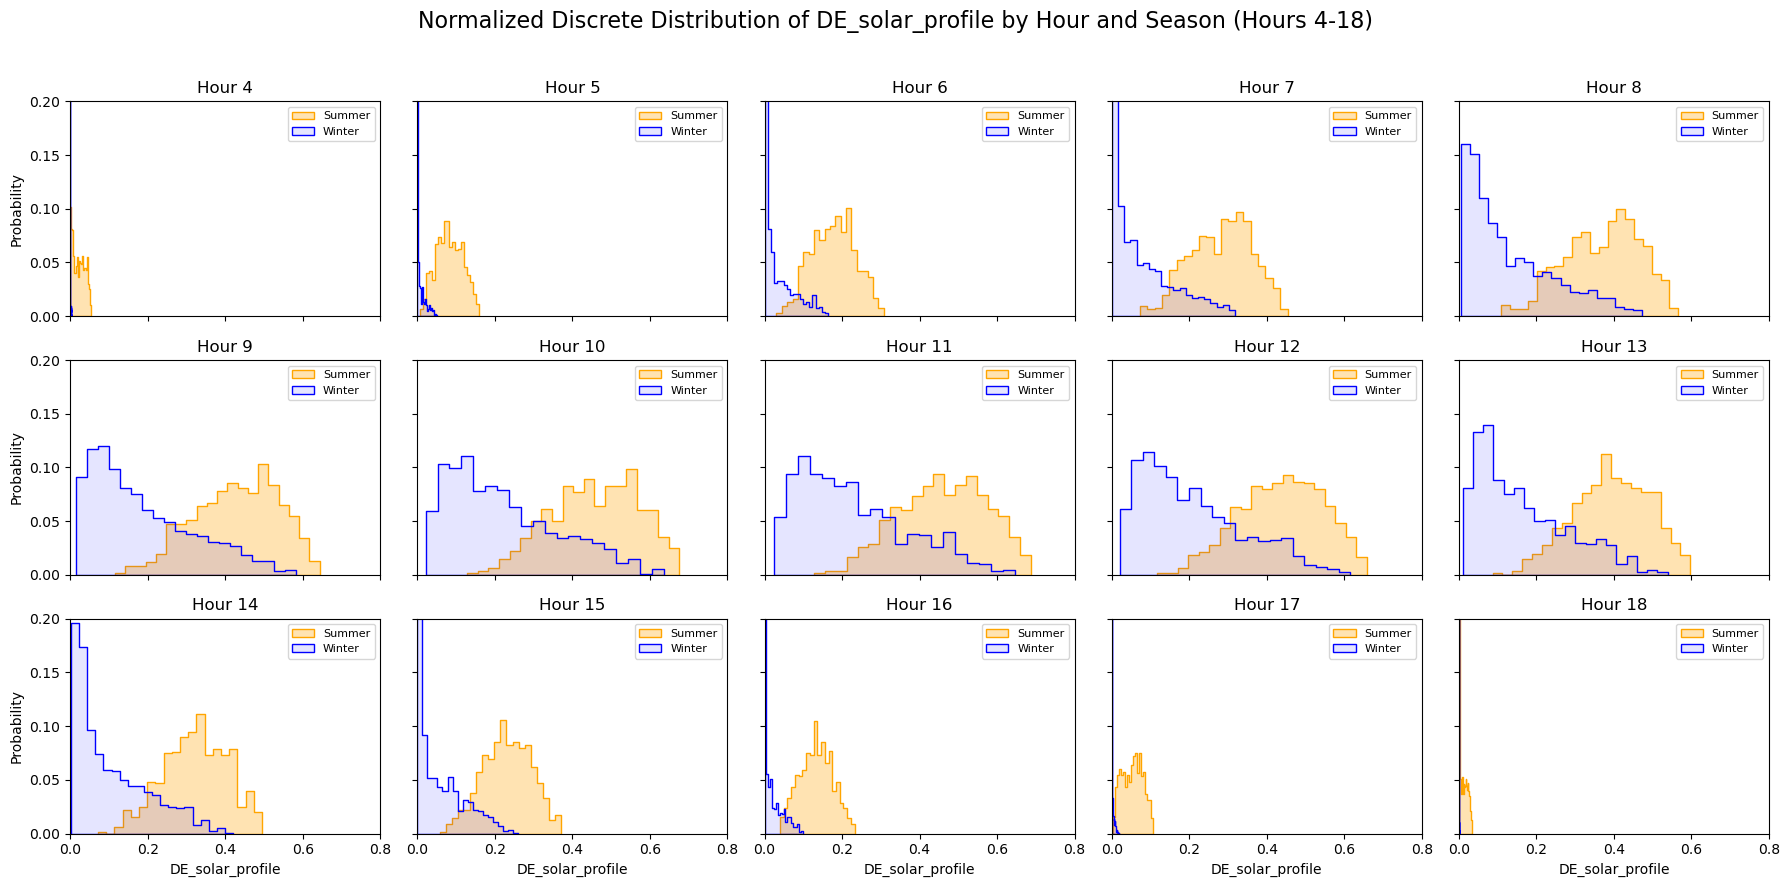

In [196]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot normalized discrete distributions for each hour (4 to 18) by season using histograms
# Function to plot normalized discrete distributions for each hour by season using histograms
def plot_normalized_distribution_by_season(df: pd.DataFrame, start_hour: int = 4, end_hour: int = 18):
    
    # Step 1: Convert 'utc_timestamp' to datetime (if not already done)
    df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
    df['hour'] = df['utc_timestamp'].dt.hour
    df['month'] = df['utc_timestamp'].dt.month

    # Step 2: Define summer and winter seasons
    df['season'] = df['month'].apply(lambda x: 'summer' if 4 <= x <= 8 else 'winter')

    # Step 3: Define hours range (based on the selected range)
    hours_range = range(start_hour, end_hour + 1)

    # Step 4: Create subplots for each hour in the range
    n_hours = len(hours_range)
    ncols = 5
    nrows = (n_hours + ncols - 1) // ncols  # Calculate rows needed based on columns and number of hours

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, nrows * 3), sharex=True, sharey=True)
    fig.suptitle(f'Normalized Discrete Distribution of DE_solar_profile by Hour and Season (Hours {start_hour}-{end_hour})', fontsize=16)

    # Flatten the axes array for easier iteration in case of a single row
    axes = axes.flatten()

    # Step 5: Iterate over each hour in the defined range and plot normalized histograms
    for idx, hour in enumerate(hours_range):
        ax = axes[idx]  # Get the appropriate subplot

        # Filter data for the current hour
        hour_data = df[df['hour'] == hour]

        # Plot normalized histogram for summer and winter on the same subplot
        sns.histplot(
            hour_data[hour_data['season'] == 'summer']['DE_solar_profile'],
            ax=ax, label='Summer', color='orange', bins=20, kde=False, stat='probability', element='step', alpha=0.3
        )
        sns.histplot(
            hour_data[hour_data['season'] == 'winter']['DE_solar_profile'],
            ax=ax, label='Winter', color='blue', bins=20, kde=False, stat='probability', element='step', alpha=0.1
        )

        ax.set_title(f'Hour {hour}')
        ax.set_xlabel('DE_solar_profile')
        ax.set_ylabel('Probability')
        ax.legend(loc='upper right', fontsize=8)
        ax.set_xlim(0,0.8)
        ax.set_ylim(0,0.2)

    # Hide any remaining empty subplots if the total is not perfectly divisible by ncols
    for idx in range(n_hours, len(axes)):
        fig.delaxes(axes[idx])

    # Step 6: Adjust layout and display the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to accommodate the title
    plt.show()

# Example usage
# energy_data_df_per_month_distribution is assumed to be your DataFrame containing the energy data.
plot_normalized_distribution_by_season(fetch_energy_data_as_dataframe(query, db_path), 4,18)


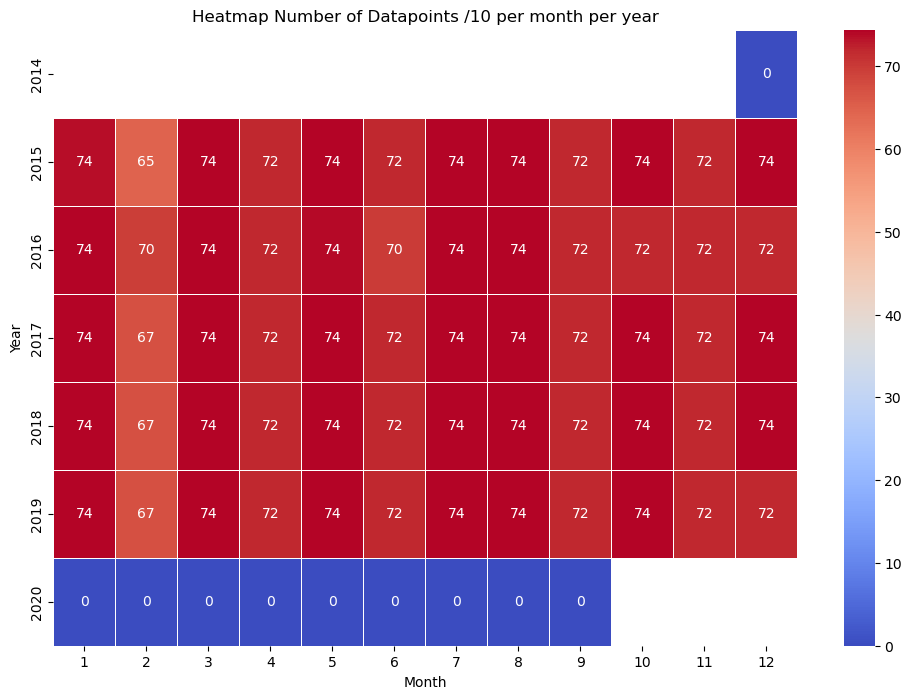

In [197]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot heatmap of missing values aggregated for all months
def plot_summed_data_heatmap(df):
    # Step 1: Convert 'utc_timestamp' to datetime (if not already done)
    df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
    df['hour'] = df['utc_timestamp'].dt.hour
    df['year'] = df['utc_timestamp'].dt.year
    df['month'] = df['utc_timestamp'].dt.month

    # Step 2: Pivot the data for heatmap (Year as rows, Hour as columns), summing the values across each month
    pivot_table = df.pivot_table(index='year', columns='month', values='DE_solar_profile', aggfunc='count')/10

    # Step 3: Plot the heatmap, showing the summed values
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
    plt.title('Heatmap Number of Datapoints /10 per month per year')
    plt.xlabel('Month')
    plt.ylabel('Year')
    plt.show()

# Example usage

plot_summed_data_heatmap(fetch_energy_data_as_dataframe(query,db_path))


In [198]:
# Example usage
db_path = 'data/time_series_weather.sqlite'  # replace with your actual database path
query = """
SELECT utc_timestamp, DE_LU_price_day_ahead,DE_load_actual_entsoe_transparency, DE_load_forecast_entsoe_transparency, DE_solar_capacity, DE_solar_generation_actual, DE_solar_profile, DE_wind_capacity, DE_wind_generation_actual, DE_wind_profile, DE_wind_offshore_capacity, DE_wind_offshore_generation_actual, DE_wind_offshore_profile, DE_wind_onshore_capacity, DE_wind_onshore_generation_actual, DE_wind_onshore_profile
FROM time_series_60min_singleindex;
    """

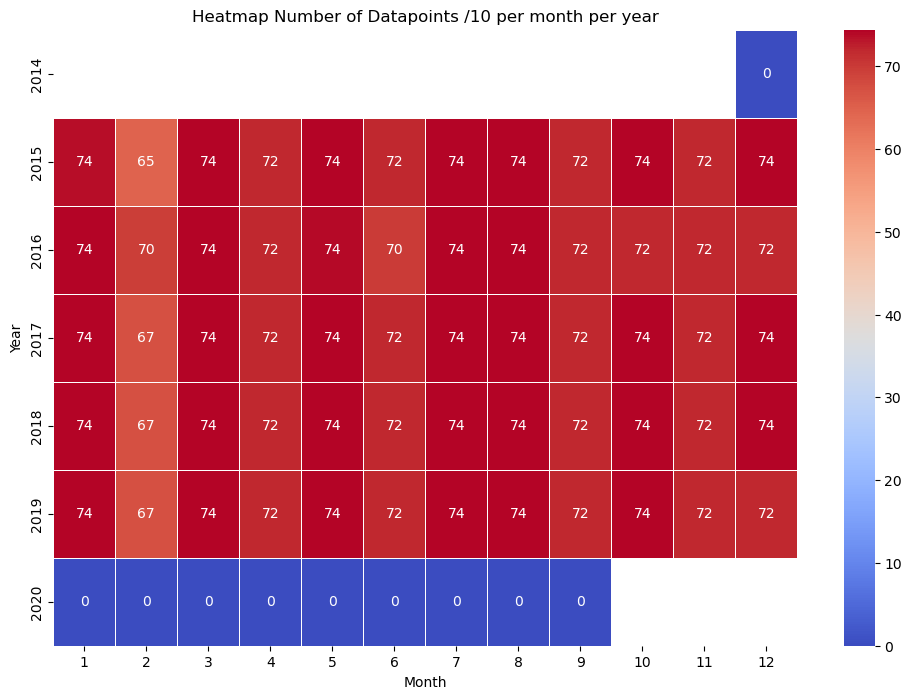

In [199]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot heatmap of missing values aggregated for all months
def plot_summed_data_heatmap(df):
    # Step 1: Convert 'utc_timestamp' to datetime (if not already done)
    df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
    df['hour'] = df['utc_timestamp'].dt.hour
    df['year'] = df['utc_timestamp'].dt.year
    df['month'] = df['utc_timestamp'].dt.month

    # Step 2: Pivot the data for heatmap (Year as rows, Hour as columns), summing the values across each month
    pivot_table = df.pivot_table(index='year', columns='month', values='DE_solar_profile', aggfunc='count')/10

    # Step 3: Plot the heatmap, showing the summed values
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
    plt.title('Heatmap Number of Datapoints /10 per month per year')
    plt.xlabel('Month')
    plt.ylabel('Year')
    plt.show()

# Example usage

plot_summed_data_heatmap(fetch_energy_data_as_dataframe(query,db_path))

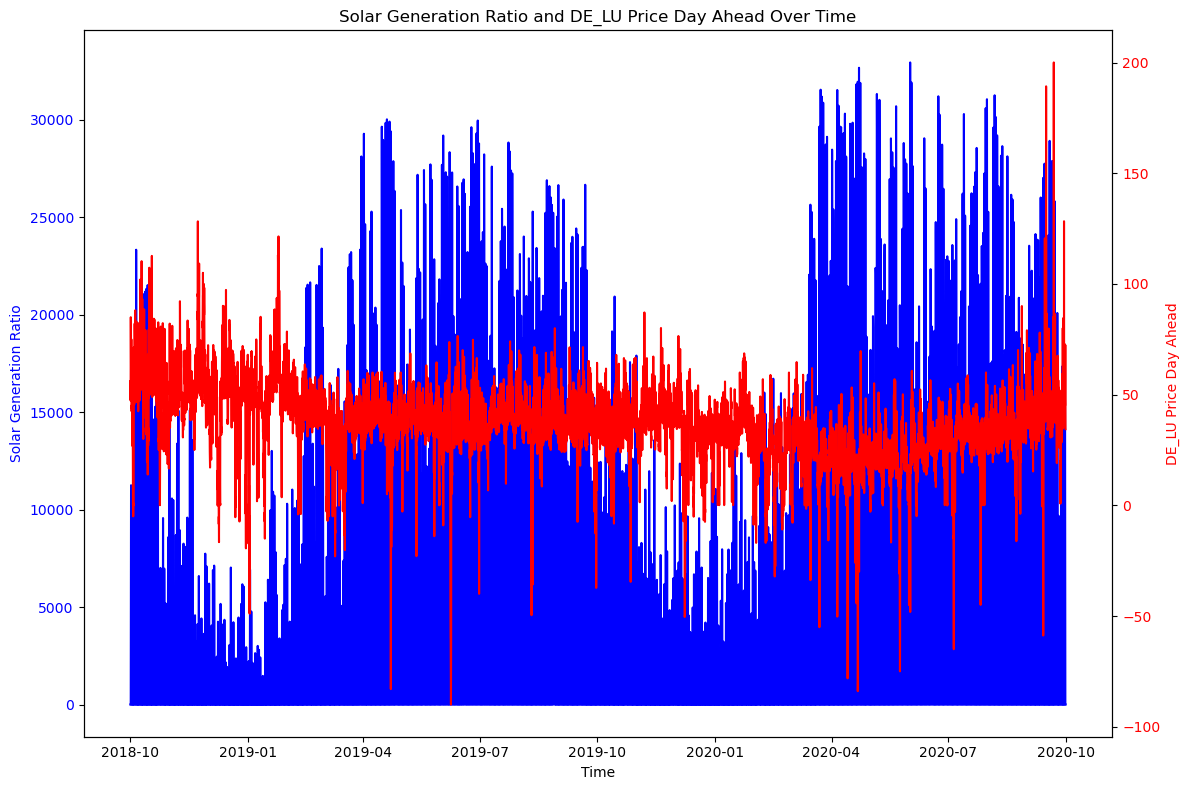

In [200]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot heatmap of missing values aggregated for all months
import pandas as pd
import matplotlib.pyplot as plt

def plot_summed_data_heatmap(df):
    # Step 1: Convert 'utc_timestamp' to datetime (if not already done)
    df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
    df['hour'] = df['utc_timestamp'].dt.hour
    df['year'] = df['utc_timestamp'].dt.year
    df['month'] = df['utc_timestamp'].dt.month

    # Step 2: Calculate the solar generation ratio
    df['solar_generation_ratio'] = df['DE_solar_generation_actual'] #/ df['DE_solar_capacity']

    # Step 3: Filter the data to ensure both columns have data for the same dates
    df = df.dropna(subset=['solar_generation_ratio', 'DE_LU_price_day_ahead'])

    # Step 4: Create a plot with two y-axes
    fig, ax1 = plt.subplots(figsize=(12, 8))

    # Plot the solar generation ratio on the primary y-axis
    ax1.plot(df['utc_timestamp'], df['solar_generation_ratio'], label='Solar Generation Ratio', color='blue')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Solar Generation Ratio', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a secondary y-axis for the price data
    ax2 = ax1.twinx()
    ax2.plot(df['utc_timestamp'], df['DE_LU_price_day_ahead'], label='Price (Day Ahead)', color='red')
    ax2.set_ylabel('DE_LU Price Day Ahead', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Add a title and adjust layout
    plt.title('Solar Generation Ratio and DE_LU Price Day Ahead Over Time')
    fig.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
# energy_data_df = fetch_energy_data_as_dataframe(query, db_path)
# plot_summed_data_heatmap(energy_data_df)


# Example usage

plot_summed_data_heatmap(fetch_energy_data_as_dataframe(query,db_path))

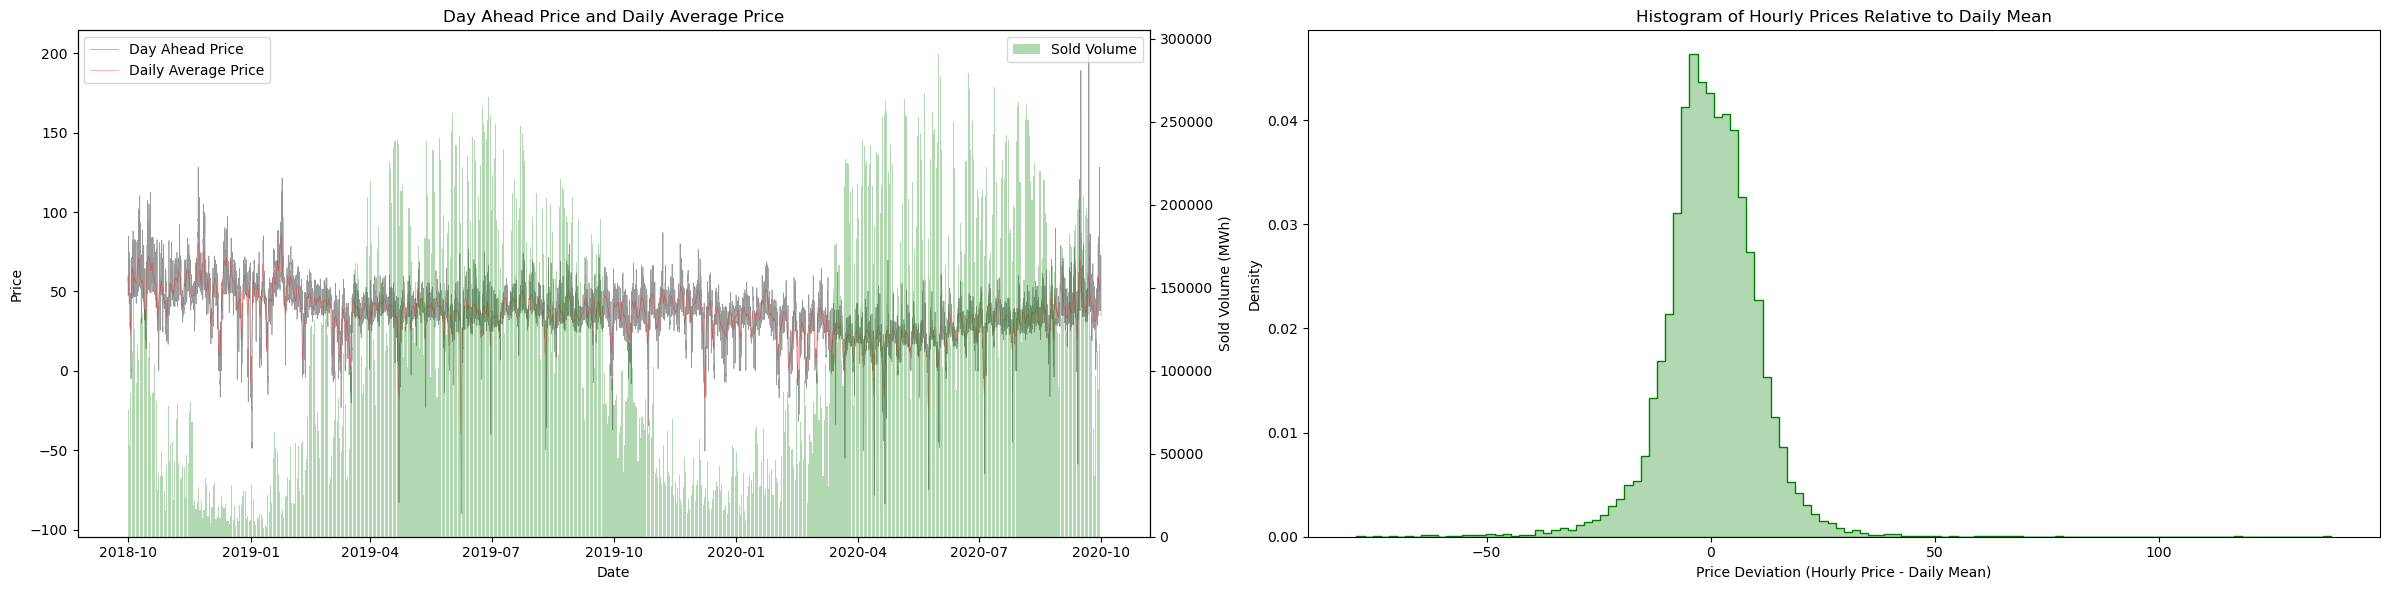

In [217]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_prices_and_probability(df):
    # Step 1: Convert 'utc_timestamp' to datetime (if not already done)
    df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
    df['date'] = df['utc_timestamp'].dt.date  # Extract the date for daily aggregation
    df['hour'] = df['utc_timestamp'].dt.hour  # Extract the hour for the pivot table

    # Step 2: Filter the data to ensure the relevant columns have data
    df = df.dropna(subset=['DE_LU_price_day_ahead', 'DE_solar_generation_actual']).copy()

    # Step 3: Calculate daily average prices
    daily_avg_price = df.groupby('date')['DE_LU_price_day_ahead'].mean()

    # Step 4: Create the figure with three subplots (side by side)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))

    # Plot 1: Day-ahead prices and daily averaged prices on the left
    ax1.plot(df['utc_timestamp'], df['DE_LU_price_day_ahead'], label='Day Ahead Price', color='black', alpha=0.4, linewidth=0.5)
    ax1.plot(daily_avg_price.index, daily_avg_price.values, label='Daily Average Price', color='red', alpha=0.4, linewidth=0.5)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.set_title('Day Ahead Price and Daily Average Price')
    ax1.grid(False)

    # Create a secondary y-axis for the sold volume (solar generation actual)
    ax1b = ax1.twinx()
    daily_volume = df.groupby('date')['DE_solar_generation_actual'].sum()
    ax1b.bar(daily_volume.index, daily_volume.values, color='green', alpha=0.3, label='Sold Volume')
    ax1b.set_ylabel('Sold Volume (MWh)')
    ax1b.tick_params(axis='y')

    # Avoid scientific notation on both axes
    ax1.ticklabel_format(style='plain', axis='y')
    ax1b.ticklabel_format(style='plain', axis='y')

    # Add legends
    ax1.legend(loc='upper left')
    ax1b.legend(loc='upper right')

    # Step 5: Calculate the probability matrix for price above/below daily mean
    df['price_above_daily_mean'] = df.apply(
        lambda row: row['DE_LU_price_day_ahead'] - daily_avg_price.loc[row['date']],
        axis=1
    ).astype(int)

    # Create a pivot table to show the probability over time
    histogram = df.pivot_table(
        index='date', columns='hour', values='price_above_daily_mean', aggfunc='mean'
    )

    # Step 6: Calculate price deviations for histogram
    df['price_deviation'] = df.apply(
        lambda row: row['DE_LU_price_day_ahead'] - daily_avg_price.loc[row['date']],
        axis=1
    )

    # Plot 3: Histogram of price deviations
    sns.histplot(df['price_deviation'], bins=120, kde=False, ax=ax2, color='green', stat='density', element='step', alpha=0.3)
    ax2.set_title('Histogram of Hourly Prices Relative to Daily Mean')
    ax2.set_xlabel('Price Deviation (Hourly Price - Daily Mean)')
    ax2.set_ylabel('Density')
    ax2.grid(False)
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Example usage:
energy_data_df = fetch_energy_data_as_dataframe(query, db_path)
plot_prices_and_probability(energy_data_df)


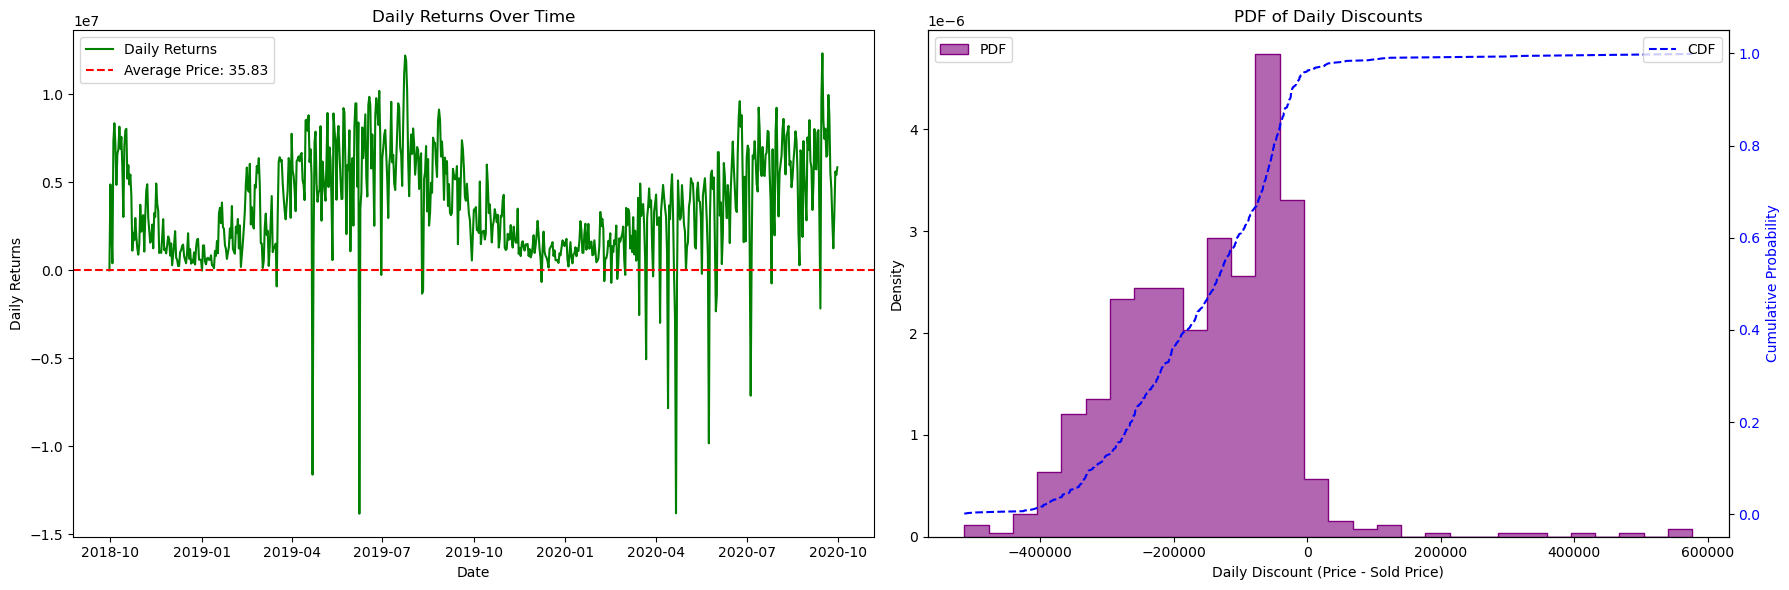

In [202]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_generation_price_returns(df):
    # Step 1: Convert 'utc_timestamp' to datetime (if not already done)
    df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
    df['hour'] = df['utc_timestamp'].dt.hour
    df['year'] = df['utc_timestamp'].dt.year
    df['month'] = df['utc_timestamp'].dt.month
    df['date'] = df['utc_timestamp'].dt.date  # Extract the date for daily aggregation

    # Step 3: Filter the data to ensure both columns have data for the same dates
    df = df.dropna(subset=['DE_solar_generation_actual', 'DE_LU_price_day_ahead']).copy()

    # Step 4: Calculate the daily returns and the daily discount using .loc on the copied DataFrame
    df.loc[:, 'daily_return'] = df['DE_solar_generation_actual'] * df['DE_LU_price_day_ahead']
    df.loc[:, 'daily_discount'] = df['DE_LU_price_day_ahead'] - df['DE_solar_generation_actual'] * df['DE_LU_price_day_ahead']

    # Step 5: Aggregate the daily returns by date
    daily_returns = df.groupby('date')['daily_return'].sum()
    daily_discounts = df.groupby('date')['daily_discount'].mean()

    # Calculate the overall average price for reference
    daily_avg_price = df.groupby('date')['DE_LU_price_day_ahead'].mean()
    avg_price = daily_avg_price.mean()

    # Step 6: Create the figure with two subplots (side by side)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Plot 1: Daily returns over time with average price line
    ax1.plot(daily_returns.index, daily_returns.values, label='Daily Returns', color='green')
    ax1.axhline(avg_price, color='red', linestyle='--', label=f'Average Price: {avg_price:.2f}')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Daily Returns')
    ax1.set_title('Daily Returns Over Time')
    ax1.grid(False)
    ax1.legend(loc='upper left')

    # Plot 2: Histogram of the daily discount
    sns.histplot(daily_discounts, bins=30, kde=False, ax=ax2, color='purple', stat='density', element='step', alpha=0.6)
    ax2.set_xlabel('Daily Discount (Price - Sold Price)')
    ax2.set_ylabel('Density')
    ax2.set_title('PDF of Daily Discounts')

    # Create a second y-axis for the CDF of the daily discounts
    ax3 = ax2.twinx()

    # Calculate the CDF for daily discounts
    sorted_discounts = daily_discounts.sort_values()
    cdf = sorted_discounts.rank(method='first') / len(sorted_discounts)

    # Plot the CDF on the second y-axis
    ax3.plot(sorted_discounts.values, cdf.values, color='blue', label='CDF', linestyle='--')
    ax3.set_ylabel('Cumulative Probability', color='blue')
    ax3.tick_params(axis='y', labelcolor='blue')

    # Add legends for the second plot
    ax2.legend(['PDF'], loc='upper left')
    ax3.legend(['CDF'], loc='upper right')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Example usage:
energy_data_df = fetch_energy_data_as_dataframe(query, db_path)
plot_generation_price_returns(energy_data_df)
